# ***AUTHORS***

## *Clovis Lechien*

# ***TEAM NAME***

## *Professional Gooner*

# ***=============================================***

# ***Summary of all things done/tried***

1. ***Seed Optimization***
    1. Best Seed Search on 32 batch size
    1. Best Seed Search on 64 batch size
1. ***Data Augmentation***
    1. RandomFlip => Used
    1. RandomRotation
    1. RandomZoom => Used
    1. RandomContrast => Used
    1. RandomBrightness
1. ***Class Weights***
    1. Train Dataset
    1. Validation Dataset
    1. Both Datasets fused => Used this one, thanks to my seed optimization from before the difference with using the train dataset one is minimal, so I can also improve a little bit on the validation set
1. ***Model Tuning***
    1. Optimal Convolution depths
    1. Optimal Convolution kernel sizes
    1. Optimal Dropout rate
    1. Optimal Dense depths
    1. Optimal MaxPooling sizes
    1. Optimal Regularization methods
1. ***Hyperparameter tuning and training optimization***
    1. Optimal learning rate search
    1. Learning rate scheduler
    1. Reduce LR on Plateau
    1. Early Stopping
    1. Callbacks
1. ***Model Explainability***
    1. Confusion Matrixes
    1. Model History (accuracy, loss)
1. ***Archtectures tried but not kept***
    1. Recurrent convolutionnal network
    1. Separable convolution network

In [1]:
# Quelques informations sur les données:

# TAILLE IMAGE : 128 x 192 x 1
# CATEGORIES:
# {'coastguard_scaled': 0, 'containership_scaled': 1, 'corvette_scaled': 2, 'cruiser_scaled': 3, 'cv_scaled': 4, 'destroyer_scaled': 5, 'methanier_scaled': 6, 'smallfish_scaled': 7, 'submarine_scaled': 8, 'tug_scaled': 9}

# Architecture:
# working/test.npy
# /working/ships_gray/{CATEGORY}/{IMAGE_ID}.jpg
# /working/ships_gray/...

# exemple: /working/ships_gray/coastguard_scaled/2414.jpg
# ID:
# 2414
# CATEGORY:
# coastguard_scaled : 0

In [2]:
!tar xzf /kaggle/input/navires-2024-fait-main/ships24.tgz

# ***Imports***

#### Nous importons seulement les librairies qui nous seront utiles pour la suite:
1. ***Utils***: des librairies pour manipuler la données de manière générale.
2. ***Plotting***: des librairies pour visualiser et comprendre les données.
3. ***Dev QOL***: des librairies pour appliquer des techniques basiques pour améliorer la performance et la compréhension du modèle.
4. ***Model Creation***: équivoque
5. ***Model Optimization***: des librairies pour appliquer des techniques avancées d'optimisation du modèle, principalement durant l'entraînement.
6. ***Model Tuning***: deux librairies d'optimization et de recherche d'hyperparamètres pour améliorer les performances du modèle de manière significative.

In [3]:
# Utils
import os
import numpy as np
import pandas as pd
from typing import List, Tuple
import math

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Dev QOL
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# Model Creation
import keras
from keras import layers
from keras import regularizers

# Model Optimization
import tensorflow as tf
from tensorflow import data as tf_data
import tensorflow_decision_forests as tfdf
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

# Model Tuning - Hyperparameter Optimization
import optuna
import keras_tuner as kt

2024-06-02 13:07:38.409451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 13:07:38.409562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 13:07:38.534952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ***Creating the Dataframes***

#### Après recherche sur le jeu de données, nous déterminons que nos images sont de tailles (128, 192).\
#### Nous décidons également d'importer les images par batch de taille 32, cette taille de batch sera également utilisée durant l'entraînement du modèle.

In [4]:
image_size = (128, 192)
batch_size = 32 # 64 gives out the same results

#### Ces deux fonctions servent à calculer la répartition des données dans chacune des 10 classes.

#### Elles ont deux utilités dans mon notebook:
1. ***Seed Optimzation***: Je vais importer les données avec plusieurs seed différentes et ne garder que celle qui possède la répartition la plus équilibrée de données (avec l'écart-type le plus faible inter-catégorie) à la fois sur le dataset de training et sur celui de validation (donc on fait également une moyenne entre les deux dataset).

2. ***Class Weight Computation***: Une méthode qui vise à équilibrer le poids des classes pendant l'entraînement du modèle, dans un monde idéal nos 10 classes seraient répartis identiquement, or ce n'est pas le cas. Afin d'éviter que les classes sur-représentées influent trop sur le modèle nous calculons des poids qui permettent de réguler leur influence.

In [5]:
# On récupère pour chaque classe du jeu de données (d'entraînement ou de validation) le nombre d'image 
def get_class_counts(df):
    class_counts_dict = {}
    
    for images, labels in df:
        label_indices = np.argmax(labels, axis=1)
        unique_classes, class_counts = np.unique(label_indices, return_counts=True)
        for cls, count in zip(unique_classes, class_counts):
            class_counts_dict[cls] = class_counts_dict.get(cls, 0) + count
    
    return class_counts_dict

#### Voici ma fonction de recherche sur la meilleure seed pour importer les données:
1. On importe les données avec une seed particulière
2. On calcule l'écart-type des données d'entraînement et de validation
3. On calcule la moyenne de ces écart-types et on met à jour ou non la meilleure seed

In [6]:
def find_best_seed(min_seed, max_seed):
    best_seed = 69
    best_mean_std = math.inf
    
    for seed in range(min_seed, max_seed):
        
        df_train, df_vali = keras.utils.image_dataset_from_directory(
            "/kaggle/working/ships_gray",
            label_mode="categorical",
            validation_split=0.2,
            subset="both",
            seed=seed,
            image_size=image_size,
            batch_size=batch_size,
            color_mode="grayscale",
            verbose=0
        )
        
        class_distribution_train = pd.DataFrame.from_dict(get_class_counts(df_train), orient='index', columns=['train_count'])
        class_distribution_vali = pd.DataFrame.from_dict(get_class_counts(df_vali), orient='index', columns=['vali_count'])
        
        std_train = class_distribution_train['train_count'].std()
        std_vali = class_distribution_vali['vali_count'].std()
        
        current_mean_std = (std_train + std_vali) / 2
        
        if current_mean_std < best_mean_std :
            best_seed = seed
            best_mean_std = current_mean_std
            print(f"best seed: {best_seed} --- best mean std: {best_mean_std}\n\n")
    
    return best_seed

#### En l'occurence ici pour un taille de batch à 32 notre meilleure seed entre 0 et 250 est 154.\

#### Pour une batch size à 64 la meilleure seed dans la même range est 80.

#### J'ai décidé de ne pas étendre les recherches de seed à une range plus grande car la seed trouvée offre déjà une répartition quasi parfaite entre le jeu de données d'entraînement et de validation pour nos données.

In [7]:
best_seed = 154 # find_best_seed(0, 250)

In [8]:
df_train, df_vali = keras.utils.image_dataset_from_directory(
    "/kaggle/working/ships_gray", # l'emplacement de nos données
    label_mode="categorical", # classification multi classes à 10 labels
    validation_split=0.2, # 80% des données servent à l'entraînement et 20% à la validation
    subset="both", # pour récupérer à la fois df_train et df_vali
    seed=best_seed, # notre meilleure seed d'import des données
    image_size=image_size, # la taille de nos images : (128 x 192)
    batch_size=batch_size, # la taille du batch d'import : 32
    color_mode="grayscale" # les images sont importées avec 1 seul channel de couleur : (128 x 192 x 1)
)

Found 42204 files belonging to 10 classes.
Using 33764 files for training.
Using 8440 files for validation.


# ***Visualizing the Data***

#### Cette partie nous permet par exemple de comprendre pourquoi nous avons effectué une recherche sur la meilleure seed.

#### Comme vous pourrez le voir, les 10 classes ne possèdent malheureusemen pas chacune 10% des données.

In [9]:
class_distribution_train = pd.DataFrame.from_dict(get_class_counts(df_train), orient='index', columns=['train_count'])
class_distribution_train

,train_count
0,2770
1,5581
2,2383
3,5569
4,1614
5,5324
6,2800
7,2692
8,2276
9,2755


In [10]:
class_distribution_vali = pd.DataFrame.from_dict(get_class_counts(df_vali), orient='index', columns=['vali_count'])
class_distribution_vali

,vali_count
0,706
1,1382
2,591
3,1377
4,415
5,1322
6,725
7,657
8,571
9,694


In [11]:
# On récupère les noms des 10 classes pour comprendre plus facilement le déséquilibre inter-classes
class_names = ['coastguard_scaled', 'containership_scaled', 'corvette_scaled', 'cruiser_scaled', 'cv_scaled', 'destroyer_scaled', 'methanier_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']

#### **Comme vous pouvez le voir, grâce à notre recherche de la meilleure seed la différence de distribution des données entre le dataset de train et celui de validation ne dépasse pas les 0.3% pour 2 catégories identiques.**

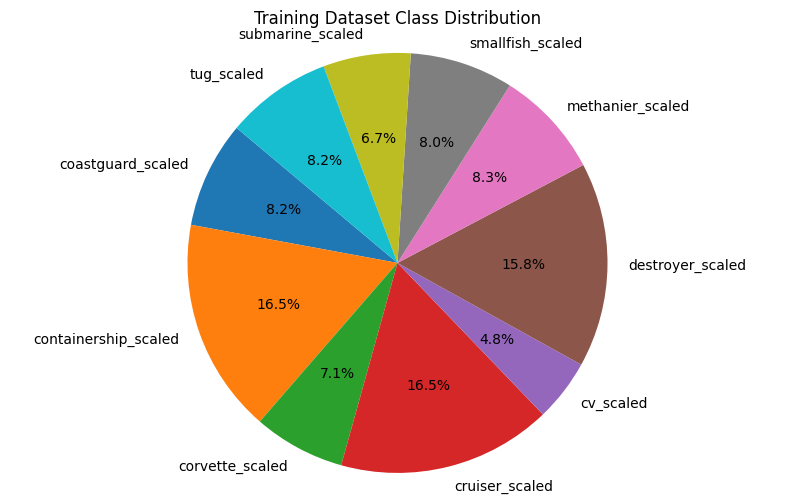

In [12]:
plt.figure(figsize=(10, 6))
plt.pie(class_distribution_train['train_count'], labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Training Dataset Class Distribution')
plt.axis('equal')
plt.show()

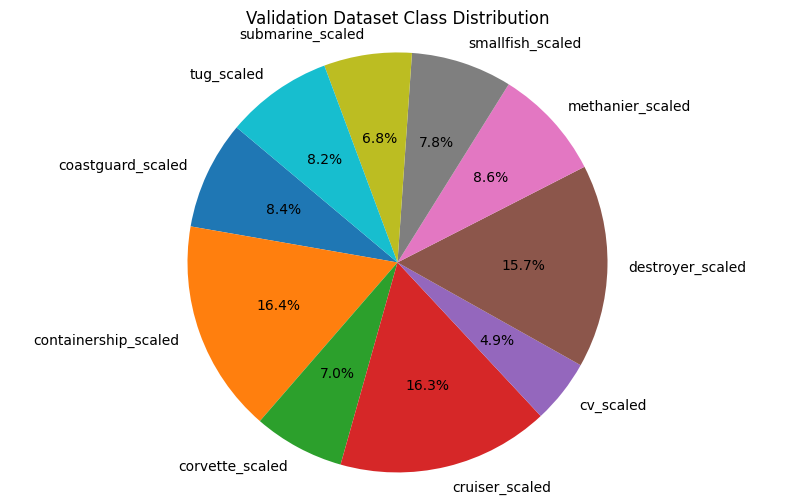

In [13]:
plt.figure(figsize=(10, 6))
plt.pie(class_distribution_vali['vali_count'], labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Validation Dataset Class Distribution')
plt.axis('equal')
plt.show()

#### Pour vous montrer à quelle point cette différence importe, je vous propose d'importer les données avec une **'mauvaise seed'** et de regarder la répartition des données.

#### On changera simplement la valeur de la seed pour l'import des données, le reste est indentique aux étapes précédentes.

In [14]:
df_train_bad, df_vali_bad = keras.utils.image_dataset_from_directory(
    "/kaggle/working/ships_gray",
    label_mode="categorical",
    validation_split=0.2,
    subset="both",
    seed=46884, # On met une valeur de seed arbitraire
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale"
)

class_distribution_train_bad = pd.DataFrame.from_dict(get_class_counts(df_train_bad), orient='index', columns=['train_count'])
class_distribution_vali_bad = pd.DataFrame.from_dict(get_class_counts(df_vali_bad), orient='index', columns=['vali_count'])

Found 42204 files belonging to 10 classes.
Using 33764 files for training.
Using 8440 files for validation.


#### Comme nous pouvons le voir ci-dessous, on a par exemple les classes **"destroyer_scaled"** et **"cv_scaled"** qui possèdent une répartion très déséquilibrée entre le dataset de train et celui de validation.

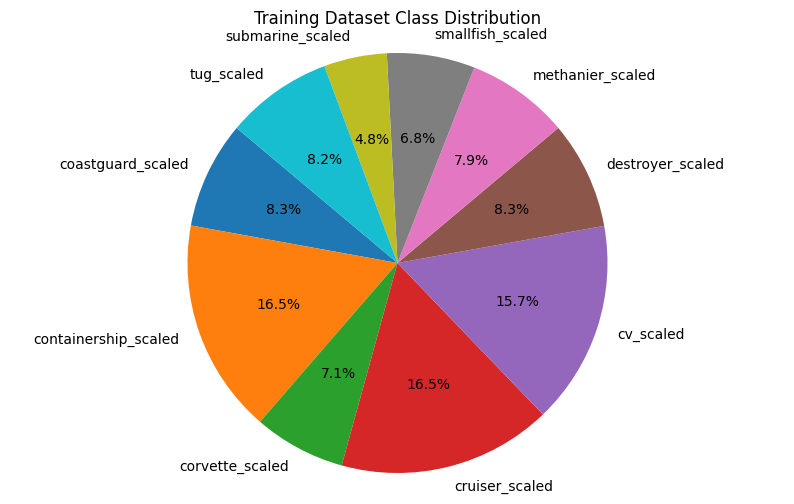

In [15]:
plt.figure(figsize=(10, 6))
plt.pie(class_distribution_train_bad['train_count'], labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Training Dataset Class Distribution')
plt.axis('equal')
plt.show()

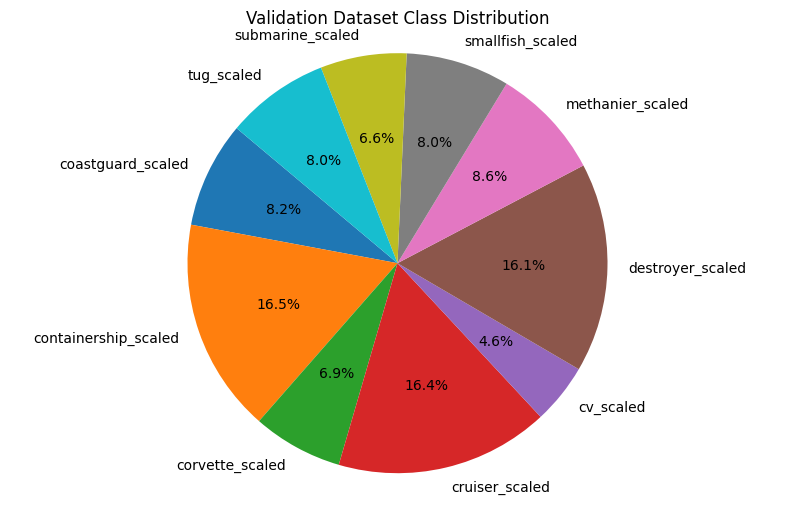

In [16]:
plt.figure(figsize=(10, 6))
plt.pie(class_distribution_vali_bad['vali_count'], labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Validation Dataset Class Distribution')
plt.axis('equal')
plt.show()

#### Afin d'apprécier nos données, voici quelques images de bateaux contenues dans nos datasets.

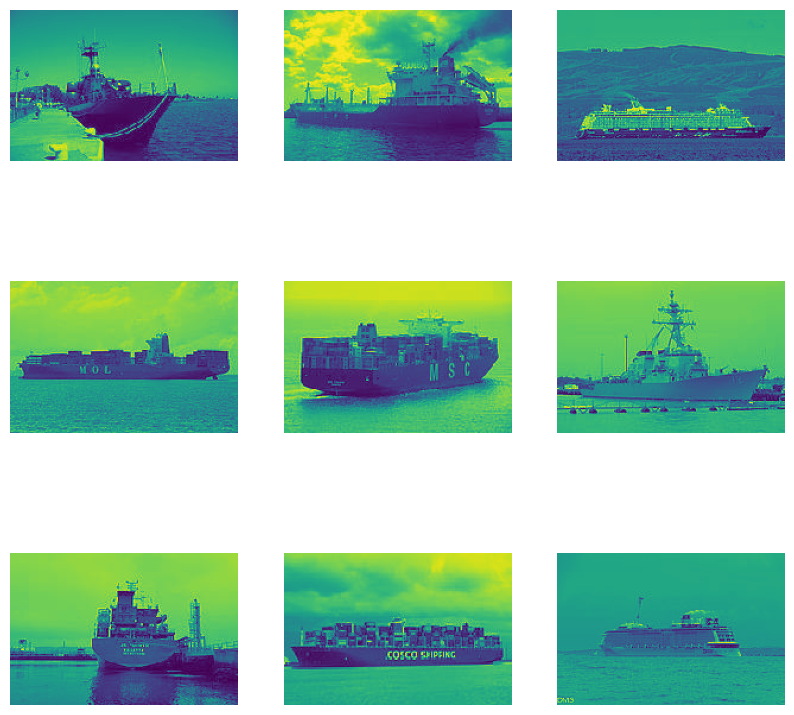

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in df_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.axis("off")

#### Ci-dessous j'ai affiché 2 images de bateau bien précis.

1. ***Un destroyer***
2. ***Une corvette***

#### En fait ces deux classes sont problématiques car les bateaux sont très similaires visuellement parlant, et la répartition des données montre un déséquilibre important.

#### Comme vu juste au dessus, on a en moyenne dans nos jeu de données d'entraînement/validation:

1. ***destroyer*** : 15.85% des images
2. ***corvette*** : 7.0% des images

#### Ce déséquilibre sera illustré plus tard dans le notebook avec la matrice de confusion du modèle après entraînement.

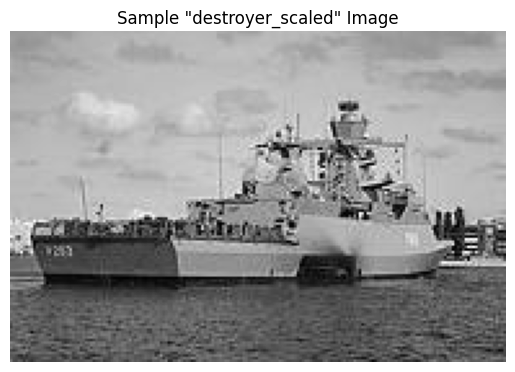

In [18]:
destroyer_scaled = 2

index = 0
for images, labels in df_train:
    if np.argmax(labels[0]) == destroyer_scaled:
        break
    index += 1

image = images[0].numpy()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Sample "destroyer_scaled" Image')
plt.show()

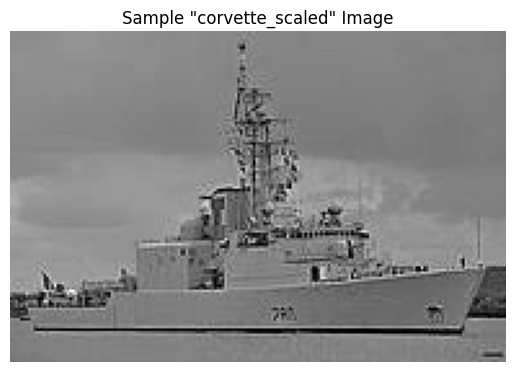

In [19]:
corvette_scaled = 5

index = 0
for images, labels in df_train:
    if np.argmax(labels[0]) == corvette_scaled:
        break
    index += 1

image = images[0].numpy()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Sample "corvette_scaled" Image')
plt.show()

### ***Fixing the class imbalances (using class weights)***

#### On va calculer ci-dessous les **"class weights"**, qui sont utilisées lors de l'entraînement du modèle pour atténuer le déséquilibre entre classes.

#### Pour se faire, on calcule celles des datasets d'entraînement et de validation, puis ont fait la moyenne des deux.

#### Comme nous nous sommes arrangés précédemment à trouver la meilleure seed d'import des données, la moyenne des deux datasets n'est pas loin ni de l'un ni de l'autre.

In [20]:
labels_list_train = []

for _, labels in df_train:
    labels_list_train.append(np.argmax(labels.numpy(), axis=1))

labels = np.concatenate(labels_list_train)

class_weights_train = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict_train = dict(enumerate(class_weights_train))
class_weight_dict_train

{0: 1.2189169675090252,
 1: 0.6049811861673535,
 2: 1.4168694922366765,
 3: 0.6062847908062489,
 4: 2.0919454770755888,
 5: 0.6341848234410218,
 6: 1.205857142857143,
 7: 1.2542347696879643,
 8: 1.4834797891036906,
 9: 1.2255535390199637}

In [21]:
labels_list_vali = []

for _, labels in df_vali:
    labels_list_vali.append(np.argmax(labels.numpy(), axis=1))

labels = np.concatenate(labels_list_vali)

class_weights_vali = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict_vali = dict(enumerate(class_weights_vali))
class_weight_dict_vali

{0: 1.1954674220963173,
 1: 0.6107091172214182,
 2: 1.428087986463621,
 3: 0.6129266521423384,
 4: 2.0337349397590363,
 5: 0.6384266263237519,
 6: 1.1641379310344828,
 7: 1.2846270928462709,
 8: 1.478108581436077,
 9: 1.2161383285302594}

In [22]:
class_weight_dict = {}

for key in class_weight_dict_train.keys():
    class_weight_dict[key] = (class_weight_dict_train[key] + class_weight_dict_vali[key]) / 2
    
class_weight_dict

{0: 1.2071921948026714,
 1: 0.6078451516943859,
 2: 1.4224787393501486,
 3: 0.6096057214742936,
 4: 2.0628402084173123,
 5: 0.6363057248823869,
 6: 1.1849975369458128,
 7: 1.2694309312671175,
 8: 1.4807941852698838,
 9: 1.2208459337751116}

# ***Data Augmentation on the DFs***

#### Dans cette partie on applique des filtres pour "augmenter les données".

#### Cela permet d'ajouter plus de diversité dans les images d'entraînement, sans pour autant impacter la répartition d'origine des données.

#### J'ai choisi de n'en appliquer que 3 sur les 6 disponibles ci-dessous car les résultats semblaient ce déteriorer après une utilisation trop importante de ces filtres:
1. **RandomFlip**
1. **RandomZoom**
1. **RandomContrast**

In [23]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.0125),
    layers.RandomZoom(height_factor=0.0125, width_factor=0.0125),
    layers.RandomContrast(0.05),
#     layers.RandomCrop(height=128, width=192),
    layers.RandomBrightness(0.025),
]

def data_augmentation(images, labels):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images, labels

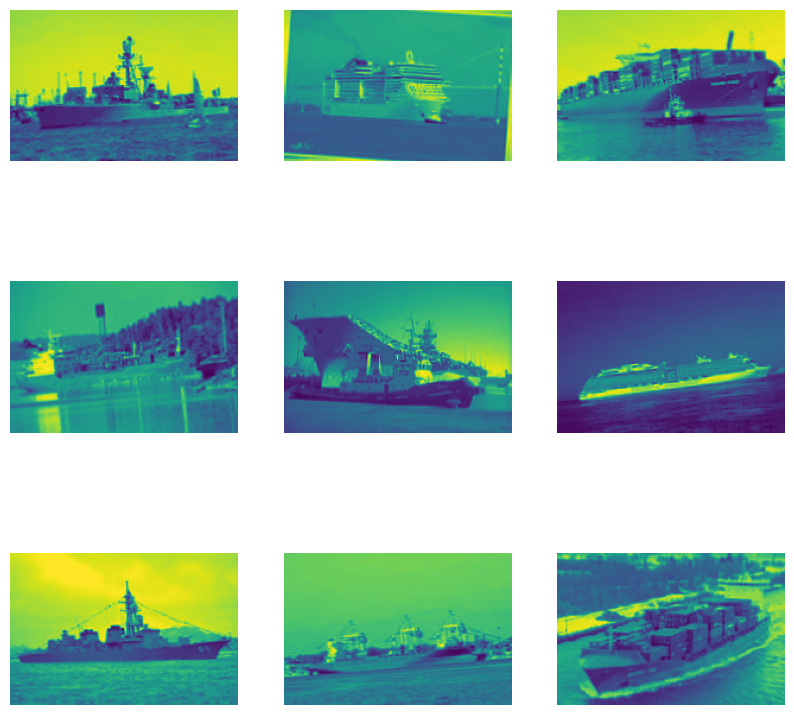

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in df_train.take(1):
    augmented_images, _ = data_augmentation(images, labels) # first transformation
    augmented_images, _ = data_augmentation(augmented_images, labels) # second transformation
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[i]).astype("uint8"))
        plt.axis("off")
plt.show()

#### Après plusieurs tests j'ai gardé seulement 3 traitements sur la donnée et les ai appliqué une fois par image, au delà les gains de performance du modèle ne se font pas ressentir.
#### Au contraire on ressent plutôt de la perte.

In [25]:
# On augmente une fois nos données avec les 3 filtres.
# J'ai essayé d'augmenter plusieurs fois les données avec ces 3 filtres mais les résultats ne sont pas assez convaincants pour justifier l'opération.
for i in range(1):
    df_train = df_train.map(
        data_augmentation,
        num_parallel_calls=tf.data.AUTOTUNE
    )

# On "rescale" nos données: (0 - 255) -> (0 - 1)
# Cela facilite énormément la tâche d'apprentissage du modèle
normalization_layer = layers.Rescaling(1./255)

df_train = df_train.map(lambda x, y: (normalization_layer(x), y))
df_vali = df_vali.map(lambda x, y: (normalization_layer(x), y))

df_train = df_train.cache().shuffle(1).prefetch(tf_data.AUTOTUNE)
df_vali = df_vali.cache().prefetch(tf_data.AUTOTUNE)

# ***Model***

Dans cette partie on définit l'architecture de notre modèle.

J'ai pu tester de nombreuses architectures, nombre de filtres de convolution, taux de dropout, .. \
et j'ai retenu celle-ci, qui produit des résultats satisfaisants, généralement autour des 93% de validation accuracy en local.

Malheureusement sur la submission cela se traduit à une précision d'environ 90,7%. \
J'aurais aimé dépasser les 91% avec tout le travail que j'ai fourni mais je pense que la chance n'était pas de mon côté..

L'allure générale du modèle est une succession de convolution, normalisation, max pooling et dropout. \
Cela assure un taux d'apprentissage uniforme, sans tomber dans l'overfitting (du moins on retarde nettement cet aspect de l'entraînement).

J'ai pu tester des architectures avec des couches résiduelles et des couches à convolution séparables mais ces-dernières ne donnaient pas de résultats intéressants.

In [26]:
# Helper Function
def build_block(last_layer: tf.Tensor, conv_num: int, kernel_size: Tuple[int,int]) -> tf.Tensor:
    
    x = layers.Conv2D(
        conv_num, # le nombre de filtres de convolution (et la dimension de sortie)
        kernel_size=kernel_size, # la taille du noyau de convolution que le modèle va apprendre
        padding='same', # on maintient le même padding utilisé précédemment.
        activation='relu', # relu: fonction d'activation
    )(last_layer) # on la connecte à la couche précédente
    
    x = layers.BatchNormalization()(x) # on normalise le batch (réduit l'overfitting)
    
    return x

In [27]:
# Helper Function
def dense_block(last_layer: tf.Tensor, neuron_num: int) -> tf.Tensor:
    
    x = layers.Dense(
        neuron_num, # units: la dimension de sortie
        activation='relu',#layers.LeakyReLU(negative_slope=0.01), # leaky relu: fonction d'activation
        kernel_regularizer=regularizers.L2(l2=2.678e-4) # régularisation L2: réduit l'overfitting
    )(last_layer) # on la connecte à la couche précédente
    
    x = layers.BatchNormalization()(x) # on normalise le batch (réduit l'overfitting)
    
    return x

In [28]:
def make_model(input_shape: Tuple[int,int,int], num_classes: int) -> keras.Model:
    """
        Builds a CNN model

        Input:
            - input_shape - a (height, width, chan) tuple, the shape of the input images
            - num_classes - number of classes the model must learn

        Output:
            model - a Keras Model() instance
    """
    
    #### INPUT ####
    x_input = keras.Input(input_shape) # la couche d'entrées du modèle, elle convertie si nécessaire les données en format utilisable par les couches suivantes.
    
    #### FIRST BLOCK ####
    x = build_block(last_layer=x_input, conv_num=256, kernel_size=(5, 5)) # 1ère Convolution: (128, 192, 1) -> (128, 192, 256) | + Normalisation
    x = build_block(last_layer=x, conv_num=256, kernel_size=(5, 5)) # 2ème Convolution: (128, 192, 256) -> (128, 192, 256) | + Normalisation
    x = layers.MaxPooling2D(pool_size=(2,3), strides=2)(x) # 1er Max Pooling: (128, 192, 256) -> (64, 95, 256)
    x = layers.Dropout(0.33)(x) # 1er Dropout (33% des neurones sont désactivées entre la couche précedente et la suivante)
    
    #### SECOND BLOCK ####
    x = build_block(last_layer=x, conv_num=384, kernel_size=(5, 5)) # 3ème Convolution: (64, 95, 256) -> (64, 95, 384) | + Normalisation
    x = build_block(last_layer=x, conv_num=384, kernel_size=(5, 5)) # 4ème Convolution: (64, 95, 384) -> (64, 95, 384) | + Normalisation
    x = layers.MaxPooling2D(pool_size=(3,3), strides=3)(x) # 2ème Max Pooling: (64, 95, 384) -> (31, 47, 384)
    x = layers.Dropout(0.33)(x) # 2ème Dropout (33% des neurones sont désactivées entre la couche précedente et la suivante)
    
    #### THIRD BLOCK ####
    x = build_block(last_layer=x, conv_num=512, kernel_size=(5, 5)) # 5ème Convolution: (64, 95, 384) -> (64, 95, 512) | + Normalisation
    x = build_block(last_layer=x, conv_num=512, kernel_size=(5, 5)) # 6ème Convolution: (64, 95, 512) -> (64, 95, 512) | + Normalisation
    x = layers.MaxPooling2D(pool_size=(3,3), strides=3)(x) # 3ème Max Pooling: (64, 95, 512) -> (10, 15, 512)
    x = layers.Dropout(0.33)(x) # 3ème Dropout (33% des neurones sont désactivées entre la couche précedente et la suivante)
    
    #### BRIDGE BLOCK ####
    x = layers.Flatten()(x) # Flatten: (10, 15, 512) -> 76800 (=10 * 15 * 512)
#     x = layers.GlobalAveragePooling2D()(x) # Similaire dans l'usage à Flatten, permet cependant de réduire l'overfitting. (10, 15, 512) -> 512
    x = layers.Dropout(0.73958)(x) # 4ème Dropout (73,958% des neurones sont désactivées entre la couche précedente et la suivante)
    
    #### DENSE BLOCK ####
    x = dense_block(last_layer=x, neuron_num=1000) # 1ère Couche Dense: 76800-> 512 | + Normalisation
    x = layers.Dropout(0.5)(x) # 5ème Dropout (50% des neurones sont désactivées entre la couche précedente et la suivante)
    
    x = dense_block(last_layer=x, neuron_num=1000) # 2ème Couche Dense: 512-> 512 | + Normalisation
    x = layers.Dropout(0.5)(x) # 6ème Dropout (50% des neurones sont désactivées entre la couche précedente et la suivante)
    
    x = dense_block(last_layer=x, neuron_num=1000) # 3ème Couche Dense: 512-> 512 | + Normalisation
    
    #### OUTPUT ####
    outputs = layers.Dense(num_classes, activation='softmax')(x) # 4ème Couche Dense: 512-> 10 } nos 10 labels à classifier.
    
    model = keras.Model(inputs=x_input, outputs=outputs, name='CNN_v15') # Au total, j'aurais essayé pas moins de 15 modèles avec des structures différentes
    
    return model

L'hyperparamètre qui de loin influe le plus sur la qualité de l'entraînement du modèle est le ***learning rate***.

Après de nombreuses recherches sur ce-dernier, j'en suis arrivé à la conclusion que c'est un puits sans fond. \
On peut arriver à trouver une range où le learning rate sera correct mais les résultats ne seront jamais identiques.

Une valeur qui fonctionne bien cependant pour commencer l'entraînement dans mon cas est **2.5e-4** (trouvée grâce à optuna). \
Cela a été compliquée de trouver une valeur qui arrive à donner des résultats uniformes et satisfaisants.

In [29]:
model = make_model(input_shape=image_size + (1,), num_classes=10)

initial_learning_rate = 2.5e-4

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate), # On utilise Adam comme optimizer pour notre modèle.
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'] 
)

Voilà l'architecture complète du modèle, ainsi que son nombre de couches, 30.

Cette visualisation du modèle a été très utile pour déterminer des valeurs censées pour la taille du kernel des convolutions ainsi que la taille du pooling pour les max pooling.

Ce modèle commence à avoir une taille significative en mémoire à cause des filtres de convolutions importants, de la couche Flatten et du nombre de neurones des couches dense.

J'ai réussi avec un modèle précédent, qui utilisait la même structure mais avec des valeurs plus petites, à avoir des résultats presque aussi bon que ce modèle (89,39% d'accuracy sur la submission et 92~93% de validation accuracy en local) pour un nombre de paramètres **49.3 fois plus faible !** (ça ressemble à une blague sur le 49.3 mais ça n'en est pas une)

Le modèle précédent possèdait 1.2M de paramètres et celui là possède 59.1M de paramètres.

In [30]:
model.summary()

# keras.utils.plot_model(model, show_shapes=True)

print("Nombre de couches : ", len(model.layers))

Model: "CNN_v15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 192, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 192, 256)  │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 192, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 192, 256)  │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 192, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 95, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 95, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 95, 384)    │     2,457,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 95, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 95, 384)    │     3,686,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 95, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 31, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 31, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 31, 512)    │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 21, 31, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 31, 512)    │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 21, 31, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 10, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 10, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    35,841,00

 Total params: 57,134,130 (217.95 MB)

 Trainable params: 57,123,522 (217.91 MB)

 Non-trainable params: 10,608 (41.44 KB)

Nombre de couches :  30


# ***Model Training***

Pour l'entraînement du modèle, j'ai pu tester tous les callbacks utiles à la problématique et disponible sur keras, \
ainsi que d'effectuer des recherches d'hyperparamètres sur ces-derniers pour optimiser leur utilisation.

J'en suis donc arrivé à ces valeurs.

In [31]:
epochs = 60 # nombre d'epochs total utilisé pour entraîner le modèle.
decay_rate = 1.069420 # taux d'évolution du learning par epoch pour LearningRateScheduler
min_lr = 5e-7 # valeur minimale du learning autorisée pour ReduceLROnPlateau et LearningRateScheduler
factor=0.25 # facteur de réduction du learning rate pour ReduceLROnPlateau
callbacks = [] # liste des callbacks à utiliser pendant l'entraînement

# Permet de sauvegarder tout au long de l'entraînement le meilleur modèle.
checkpoints = keras.callbacks.ModelCheckpoint(
    "save_at_{epoch}.keras", # nom du fichier
    monitor='val_categorical_accuracy', # la métrique à suivre pour comparer les modèles
    verbose=1,
    save_best_only=True, # permet de ne sauvegarder que le meilleur modèle
    mode='max' # on compare les métriques avec une fonction max
)

# La fonction qui permet de régir l'évolution du learning rate tout au long de l'entraînement.
def scheduler(epoch, lr):
    if epoch == 0:
        return lr
    return lr * decay_rate


lr_schedule = LearningRateScheduler(scheduler)

# Permet de diminuer drastiquement le learning rate si le modèle a du mal à apprendre
reduceLR = ReduceLROnPlateau(
    monitor='val_categorical_accuracy', # la métrique à monitorer pour suivre l'évolution
    factor=factor, # on baisse le learning rate d'un certain facteur (0.2)
    patience=2, # On attend 3 epochs sans amélioration avant de baisser
    min_lr=min_lr, # on ne réduit pas le learning rate en dessous d'un certain seuil
    verbose=1,
)

# Permet d'arrêter l'entraînement prématurément si le modèle n'append plus depuis X epochs.
early_stop = EarlyStopping(
        monitor="val_categorical_accuracy", # la métrique à monitorer pour suivre l'évolution
        min_delta=1e-3, # on compare l'a précision à cette échelle : 0.00X 
        patience=7, # on attend 10 epochs sans évolution de la métrique avant d'arrêter le training
        verbose=1,
        mode='max', # on compare les métriques avec une fonction max
        restore_best_weights=True # si l'entraînement s'arrête on redonne à notre modèle ses meilleurs poids
)

callbacks.append(checkpoints)
callbacks.append(reduceLR)
callbacks.append(lr_schedule)
callbacks.append(early_stop)

### ***1 epoch fit to start off the machine***

Dans certains cas il est utile de démarrer l'entraînement d'un modèle sur un ou deux epochs afin de "réveiller" le GPU.

Ici, j'entraîne simplement le modèle sur un epoch, et je continue l'entraînement sur le reste des epochs.

On remarque une différence significative entre le temps d'éxecution du premier epoch et le temps d'éxecution des autres epochs.

In [32]:
model.fit(
    df_train,
    epochs=1,
    callbacks=callbacks,
    validation_data=df_vali,
    class_weight=class_weight_dict,
)

2024-06-02 13:08:37.589790: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng35{k2=2,k3=0} for conv (f32[32,256,128,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,128,192]{3,2,1,0}, f32[256,256,5,5]{3,2,1,0}, f32[256]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-02 13:08:37.675771: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.086094395s
Trying algorithm eng35{k2=2,k3=0} for conv (f32[32,256,128,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,128,192]{3,2,1,0}, f32[256,256,5,5]{3,2,1,0}, f32[256]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_al

1055/1056 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - categorical_accuracy: 0.2331 - loss: 3.6109

W0000 00:00:1717334385.031193      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1056/1056 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - categorical_accuracy: 0.2331 - loss: 3.6107

W0000 00:00:1717334386.529500      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-02 13:20:26.696715: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng35{k2=4,k3=0} for conv (f32[24,256,128,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,256,128,192]{3,2,1,0}, f32[256,256,5,5]{3,2,1,0}, f32[256]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-02 13:20:26.725531: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.028921756s
Trying algorithm eng35{k2=4,k3=0} for conv (f32[24,256,128,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,256,128,192]{3,2,1,0}, f32[256,256,5,5]{3,2,1,0}, f32[256]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$c


Epoch 1: val_categorical_accuracy improved from -inf to 0.43756, saving model to save_at_1.keras
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 760s 569ms/step - categorical_accuracy: 0.2332 - loss: 3.6105 - val_categorical_accuracy: 0.4376 - val_loss: 2.9484 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 1.


### ***Full training***

In [33]:
history = model.fit(
    df_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=df_vali,
    class_weight=class_weight_dict,
)

Epoch 1/60
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - categorical_accuracy: 0.4628 - loss: 2.9484
Epoch 1: val_categorical_accuracy improved from 0.43756 to 0.61161, saving model to save_at_1.keras
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 525s 498ms/step - categorical_accuracy: 0.4629 - loss: 2.9483 - val_categorical_accuracy: 0.6116 - val_loss: 2.4763 - learning_rate: 2.5000e-04
Epoch 2/60
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - categorical_accuracy: 0.5918 - loss: 2.6666
Epoch 2: val_categorical_accuracy did not improve from 0.61161
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 522s 495ms/step - categorical_accuracy: 0.5918 - loss: 2.6665 - val_categorical_accuracy: 0.5466 - val_loss: 2.7306 - learning_rate: 2.6736e-04
Epoch 3/60
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - categorical_accuracy: 0.6625 - loss: 2.5004
Epoch 3: val_categorical_accuracy improved from 0.61161 to 0.63803, saving model to save_at_3.keras
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 525s 497ms/step - categorical_accuracy: 0.6625 - l

In [34]:
# On sauvegarde notre modèle.
model.save('/kaggle/working/model.keras')

# ***Visualizing the results***

On commence par regarder l'évolution des métriques de notre modèle tout au long du training grâce à son historique d'entraînement.

Afin de mieux comprendre les résultats de notre modèle, on l'évalue sur le dataset de validation et on regarde les résultats sous forme d'une matrice de confusion.

Idéalement, on rechercherai à avoir une forte concentration des données sur la diagonale, symbolisant une classification correcte.

On repère cependant quelques points d'influence en dehors de cette diagonale, notamment entre les 2 classes problématiques citées précédemment.

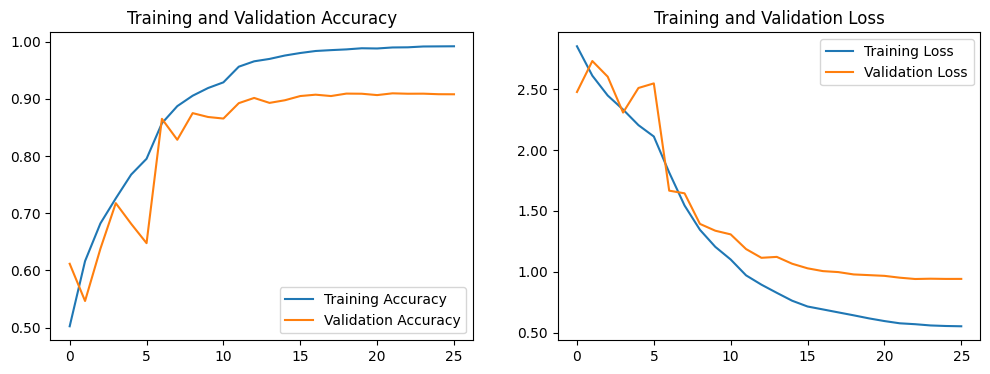

In [35]:
# On va regarder l'évolution du modèle durant l'entraînement.

def format_func(value, tick_number):
    return f'{value:.2f}'

train_accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(train_accuracy))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()

  2/264 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step 

W0000 00:00:1717348224.068612      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


264/264 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step


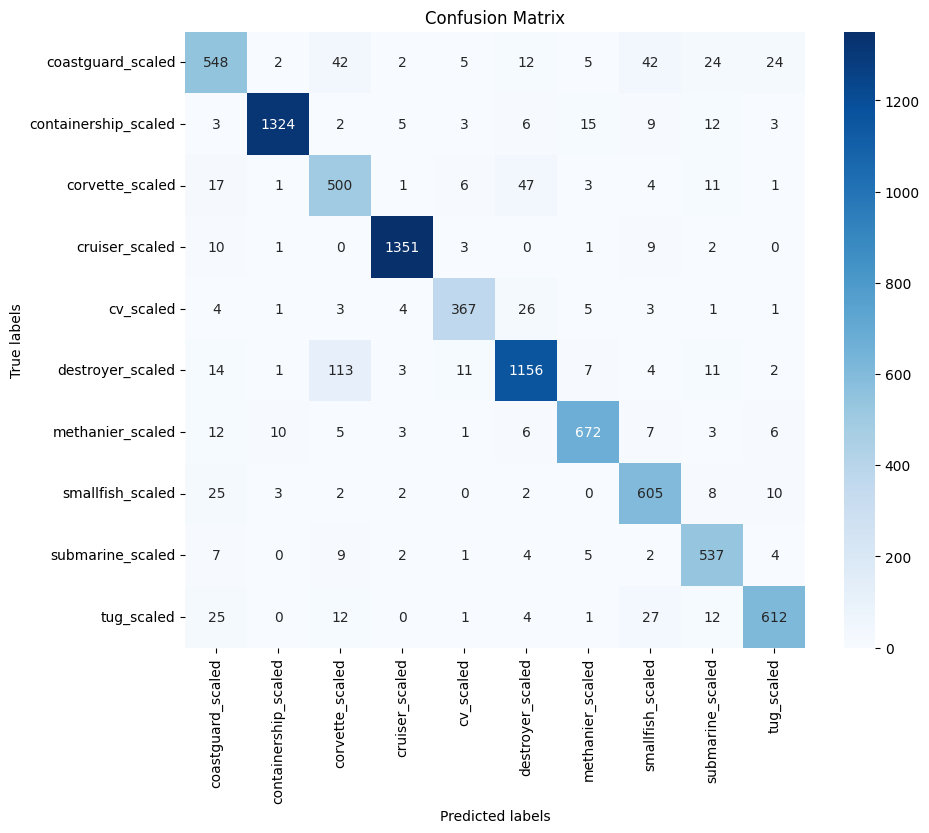

In [36]:
# On regarde ensuite la matrice de confusion du modèle après évaluation sur le dataset de validation.

predictions = model.predict(df_vali)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([np.argmax(y, axis=1) for _, y in df_vali])

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# On remarque que les deux classes qui posent le plus problème sont les suivantes:
# corvette_scaled (#2) et destroyer_scaled (#5)

# ***Submission***

Enfin, on finit par soumettre nos résultats.

In [37]:
x_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
x_test = x_test.astype('float32') / 255

res = model.predict(x_test).argmax(axis=1)

df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="ID")

os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'reco_nav.csv')

 2/32 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step 

W0000 00:00:1717348270.371612      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

2024-06-02 17:11:21.289815: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng35{k2=4,k3=0} for conv (f32[25,256,128,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,256,128,192]{3,2,1,0}, f32[256,256,5,5]{3,2,1,0}, f32[256]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-02 17:11:21.364666: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.074984113s
Trying algorithm eng35{k2=4,k3=0} for conv (f32[25,256,128,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,256,128,192]{3,2,1,0}, f32[256,256,5,5]{3,2,1,0}, f32[256]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_al

32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


/kaggle/working/reco_nav.csv

In [38]:
# On supprime les fichiers désormais inutiles une fois la procédure terminée.

!rm -rf /kaggle/working/ships_gray
!rm /kaggle/working/save_at_*.keras
!rm /kaggle/working/model.keras
!rm /kaggle/working/test.npy

# ***Hyperparameters Tuning - Optuna***

J'ai laissé en commentaire ci-dessous une des démarches suivie pour effectuer une recherche d'amélioration des hyperparamètres à l'aide d'Optuna.

Les recherches ont été faites sur un modèle antérieur.

Comme vous pouvez le voir, les paramètres suivants sont passés par une recherche extensive:
1. ***le learning rate***
1. ***le dropout rate***
1. ***les tailles des noyaux de convolution***
1. ***les profondeurs des couches denses***
1. ***les tailles des noyaux de pooling***
1. ***les profondeurs des convolutions***

In [39]:
# def build_block_optuna(last_layer, conv_num, kernel_size, pool_size, dropout_rate):
    
#     x = layers.Conv2D(conv_num, kernel_size=kernel_size, padding='same', activation='relu')(last_layer)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Conv2D(conv_num, kernel_size=kernel_size, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.MaxPooling2D(pool_size=pool_size)(x)
#     x = layers.Dropout(dropout_rate)(x)
    
#     return x

In [40]:
# def make_model_optuna(input_shape, num_classes, dropout_rate, kernel_size, pre_final_dense, final_dense, pool_size, conv_num):
    
#     x_input = keras.Input(input_shape)
    
#     x = build_block_optuna(last_layer=x_input, conv_num=conv_num, kernel_size=(kernel_size, kernel_size), pool_size=(pool_size, pool_size), dropout_rate=dropout_rate)

#     x = build_block_optuna(last_layer=x, conv_num=128, kernel_size=(kernel_size, kernel_size), pool_size=(pool_size, pool_size), dropout_rate=dropout_rate)
    
#     x = build_block_optuna(last_layer=x, conv_num=256, kernel_size=(kernel_size, kernel_size), pool_size=(pool_size, pool_size), dropout_rate=dropout_rate)
    
#     x = build_block_optuna(last_layer=x, conv_num=512, kernel_size=(kernel_size, kernel_size), pool_size=(pool_size, pool_size), dropout_rate=dropout_rate)

#     x = layers.GlobalAveragePooling2D()(x)
    
#     x = layers.Dense(pre_final_dense, activation='relu')(x)
#     x = layers.Dropout(dropout_rate)(x)
    
#     x = layers.Dense(final_dense, activation='relu')(x)
    
#     x = layers.Dense(num_classes, activation='softmax')(x)
    
#     model = keras.Model(inputs=x_input, outputs=x, name='CNN_v5')
    
#     return model
    

In [41]:
# def objective(trial):
#     learning_rate = 3e-5#trial.suggest_loguniform('learning_rate', 1e-4, 1e-6)
#     dropout_rate = 0.25#trial.suggest_uniform('dropout_rate', 0.2, 0.4)
#     kernel_size = 5#trial.suggest_int("kernel_size", 4, 6)
#     pre_final_dense = 128#trial.suggest_int("pre_final_dense", low=128, high=512, step=128)
#     final_dense = 64#trial.suggest_int("final_dense", low=64, high=256, step=64)
#     pool_size = 3#trial.suggest_int("pool_size", 2, 4)
#     conv_num = trial.suggest_int("conv_num", low=32, high=128, step=32)

#     model = make_model_optuna(input_shape=image_size + (1,), num_classes=10, dropout_rate=dropout_rate, kernel_size=kernel_size, pre_final_dense=pre_final_dense, final_dense=final_dense, pool_size=pool_size, conv_num=conv_num)

#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     history = model.fit(df_train, epochs=5, validation_data=df_vali, class_weight=class_weight_dict, callbacks=callbacks)

#     return history.history['val_accuracy'][-1]

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=4)
# best_params = study.best_params

In [42]:
# best_params

# ***Bibliographie***

* https://keras.io/
* https://www.tensorflow.org/?hl=fr
* https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html#optuna.create_study
* https://keras.io/examples/vision/image_classification_from_scratch/
* https://www.tensorflow.org/guide/keras/serialization_and_saving
* https://www.cs.toronto.edu/~lczhang/321/tut/tut06.html
* https://github.com/maxim5/hyper-engine
* https://www.tensorflow.org/tutorials/images/classification?hl=fr
* https://www.kaggle.com/code/mishki/resnet-keras-code-from-scratch-train-on-gpu
* https://www.kaggle.com/code/ahmadjaved097/multiclass-image-classification-using-cnn
* https://stackoverflow.com/questions/61230762/with-resnet50-the-validation-accuracy-and-loss-is-not-changing
* https://www.kaggle.com/code/ilanguenet/iren-competition-1-louis-guo-et-ilan-guenet
* https://www.kaggle.com/code/basth94/comp-tition-navires-2023-la-mano-rbh/notebook
* https://stackoverflow.com/questions/37020754/how-to-increase-validation-accuracy-with-deep-neural-net
* https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# ***Je vous remercie pour votre lecture***

Comme vous avez pu vous en rendre compte, j'ai passé beaucoup de temps sur ce projet à me documenter, expérimenter, et améliorer mes démarches.

Même si les résultats de mon modèle sont décevants par rapport au temps que j'ai passé sur le projet, je suis content du travail que j'ai produit et je sais que j'ai acquis de nombreuses compétences grâce à cette compétition.

- Clovis Lechien, ING2 [SCIA] - Epita 30/05/2024